<center> <h1> Topological Data Analysis</h1> <center>
<center> <h2> Exploratory Analysis using Artificially made data</h2> <center>

In this notebook, the goal is to reproduce the results presented in the paper [A Topological Data Analysis of Navigation Paths within Digital Libraries](https://ceur-ws.org/Vol-3558/paper935.pdf) using generated data. The objective is to observe the patterns that emerge when applying the method discussed in the paper while having access to all the information about user behavior.

The notebook will be divided into three main parts:

<ol>
  <li>Data Generation</li>
  <li>Paper Pipeline</li>
  <li>Discussion & Optimization</li>
</ol>

In real-life scenarios, we do not have access to the actual distributions. However, it is always beneficial to examine how these methods behave to understand their strengths and weaknesses. I will attempt to explain as thoroughly as possible, so I hope it will be clear for you.

# 1. Data Generation

The first part involves data generation. Real-world data is often messy and challenging to comprehend. My aim is to create data that closely resembles real-life scenarios, but a potential challenge arises from the fact that the data creation process may introduce biases based on my own perception of the world.

To simplify the process, I will imagine a library with various books, each dedicated to a specific topic. In reality, a single book could cover multiple topics, but for this simulation, I will assign only one topic per book. Additionally, I will incorporate features such as titles and publication dates for each book.

In [1]:
#(see tda_utils.py file for more informations)
from tda_utils import *

In [2]:
import json

#Load the small dataset
with open("toy_dataset.json", 'r') as f:

    data = json.load(f)

print("The contained themes:", *data.keys())

The contained themes: Droit Musique Histoire Science Technologie Art Cuisine Sport Mode Environnement Éducation Santé Voyages Philosophie Politique


In [3]:
for topic in data.keys():

    print("Number of themes in", topic, len(data[topic]))

Number of themes in Droit 6
Number of themes in Musique 9
Number of themes in Histoire 10
Number of themes in Science 10
Number of themes in Technologie 8
Number of themes in Art 8
Number of themes in Cuisine 8
Number of themes in Sport 7
Number of themes in Mode 6
Number of themes in Environnement 10
Number of themes in Éducation 15
Number of themes in Santé 10
Number of themes in Voyages 10
Number of themes in Philosophie 10
Number of themes in Politique 10


This is a small example of what a theme could contain as books

In [4]:
data["Droit"]

[{'title': 'Évolution des lois sur la propriété intellectuelle',
  'year': '2022'},
 {'title': "Débats actuels sur la liberté d'expression", 'year': '2021'},
 {'title': "Réformes juridiques pour la protection de l'environnement",
  'year': '2023'},
 {'title': 'Justice sociale et équité : Un examen approfondi', 'year': '2020'},
 {'title': 'Lutte contre la cybercriminalité : Enjeux contemporains',
  'year': '2022'},
 {'title': "Droits de l'homme dans le contexte mondial", 'year': '2021'}]

Now that we have our small ***"digital library,"*** we can begin constructing user behaviors. This raises the question: What constitutes a behavior in a digital library? While this question can have different answers, we will define a behavior as a recurrent pattern that appears in a navigation session. To be more precise, I will modelize a behavior as a result of a random walk on a specific transition matrix, navigating from one theme to another. Additionally, a probability distribution will be used to select a document when choosing a specific topic.

To elaborate further, let $B$ be a finite set of transition matrices, denoted as $B$ = {$B_1$,..., $B_n$}. This set provides information for navigating between topics. To navigate from one document to another within a theme, I have chosen to use a list with probabilities for each document in a specific theme, represented as $P_{theme}$ = [$P_1$, ...,$P_m$], where $P_i$ is the probability of selecting document $i$ when the ***"user decides the theme."***

Subsequently, the behavior involves the process of selecting documents using the defined probabilities. We randomly select a theme using the transition matrix $P(T=theme_i)$ and then randomly pick a document in the collection using $P(D=document_i|T=theme_i)$.

As an example, consider one transition matrix of a specific behavior $B_i$. The method below generates a transition matrix using a variability parameter that controls the probability of staying in the same theme. Higher variability leads to more uniform probabilities across the matrix.

<Axes: >

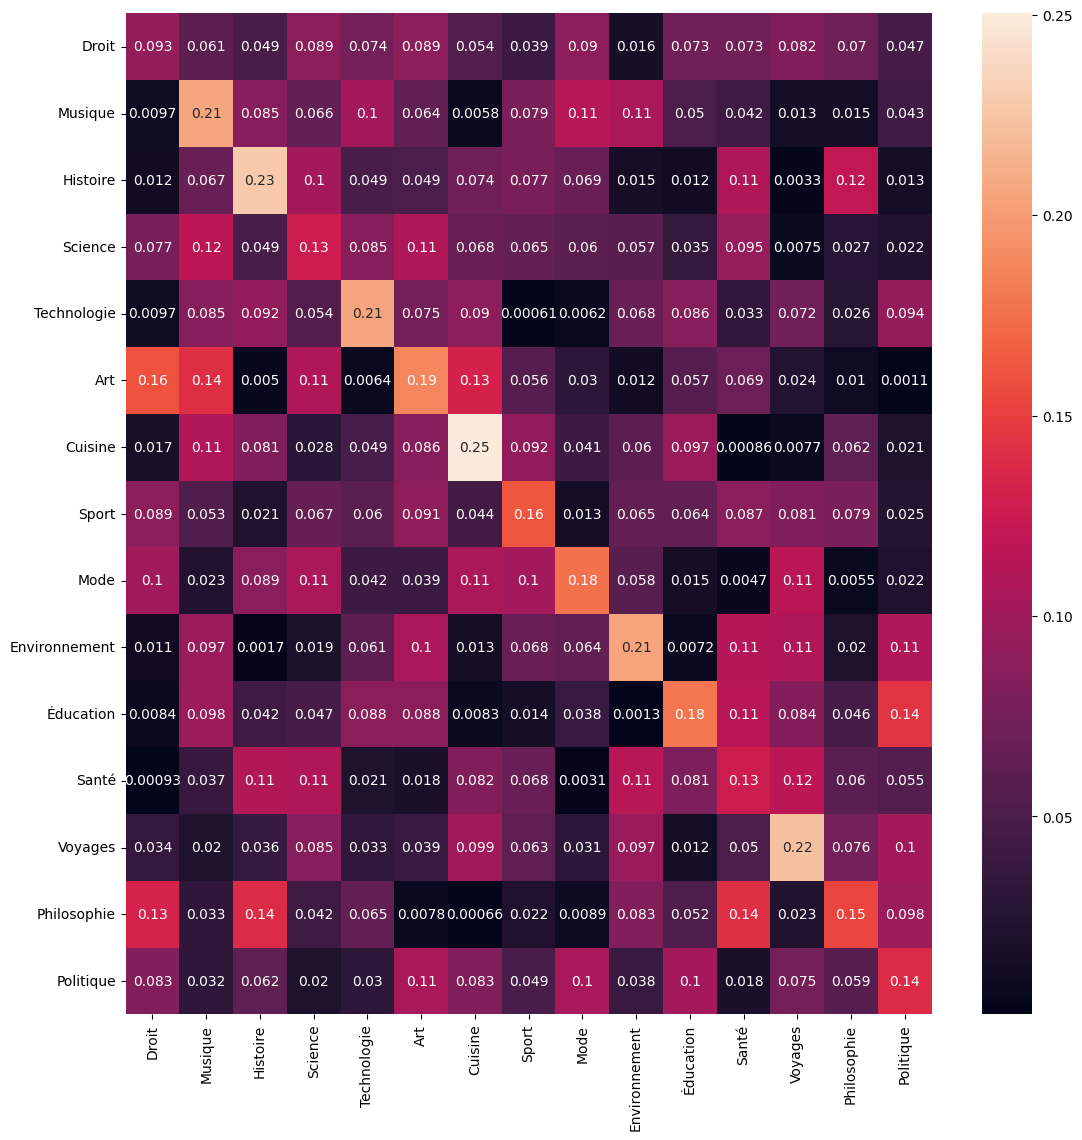

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#Change the variability parameters to get diffrent results try for example: 0.1 and 2 to see the diffrence
transition_matrix = generate_transition_matrix(data.keys(), variability=1)

tmf = pd.DataFrame(transition_matrix, index=data.keys(), columns=data.keys())

plt.figure(figsize=(13, 13))

sns.heatmap(tmf, annot=True)

The generated transition matrix is not flawless, and there are some additional details to consider. Firstly, I have only one parameter controlling the probability assigned to the elements on the diagonal (representing the probability of staying in the same topic), introducing some bias. This means that certain users may navigate with a higher probability from one topic to another, while I can achieve a nearly uniform distribution by increasing the variability parameter.

Secondly, in the way I generated the matrix, only the rows have the property of having a sum of probabilities equal to one; the columns do not have this property. However, this is not crucial because I will exclusively use the rows.

Regarding the probabilities of documents, they should also sum up to 1, but different types of distributions are possible. In my case, I opted to use the Dirichlet distribution to generate these lists. This distribution can produce lists that are almost uniformly distributed or have high variance between probabilities, depending on the parameter $\alpha$ (a higher alpha leads to a more uniform distribution). Below is an example of two lists with different parameters.

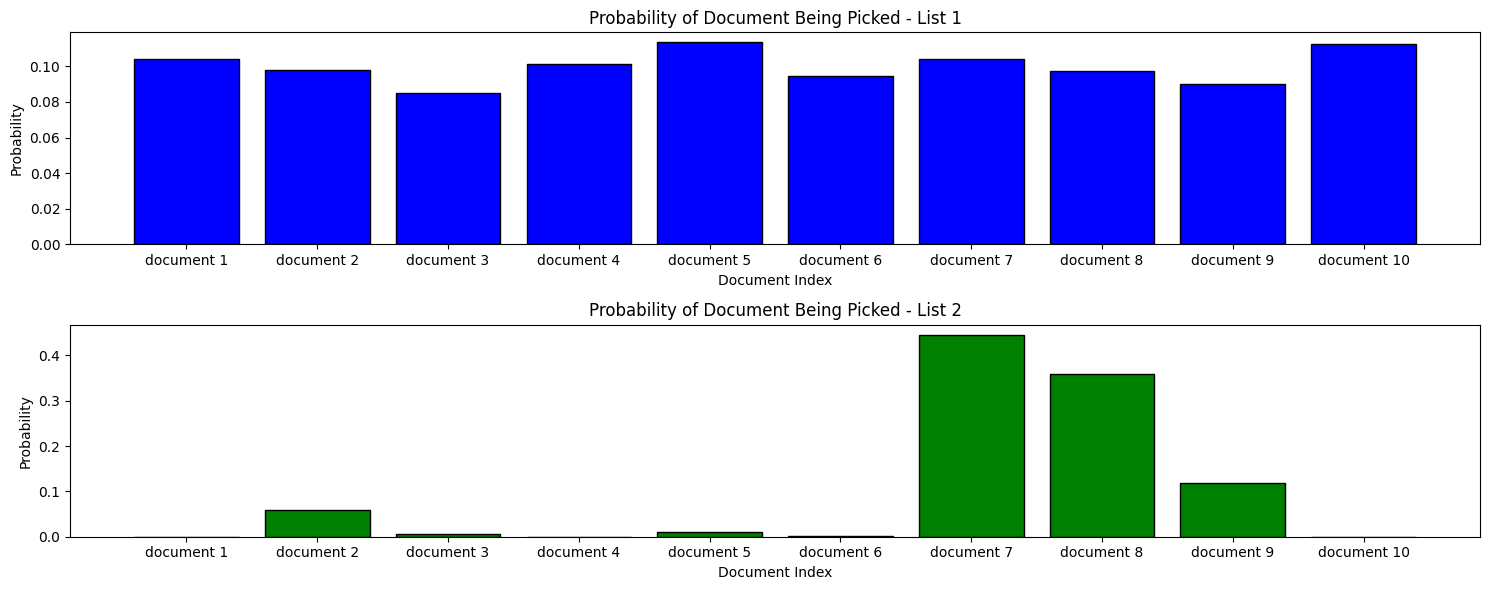

In [6]:
#Generate 2 documents probabilities distributions (there is 10 documents for this example in the lists)
doc_pro1 = np.random.dirichlet(np.ones(10)*100, size=1)

doc_pro2 = np.random.dirichlet(np.ones(10)/10, size=1)

#Index of documents (For visualization)
doc_indices = ["document "+str(i) for i in range(1, doc_pro1.shape[1]+1)]

# Create bar plots using Matplotlib's pyplot
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.bar(doc_indices, doc_pro1[0], color='blue', edgecolor='black')
plt.title('Probability of Document Being Picked - List 1')
plt.xlabel('Document Index')
plt.ylabel('Probability')

plt.subplot(2, 1, 2)
plt.bar(doc_indices, doc_pro2[0], color='green', edgecolor='black')
plt.title('Probability of Document Being Picked - List 2')
plt.xlabel('Document Index')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

We can now generate our data, utilizing the two parameters, variability and the $\alpha$ parameter of the Dirichlet distribution. This provides us with a broad spectrum of possible behaviors. Although the model generating the data does not fully capture reality, missing many details, I would like to introduce a last parameter, which is the session action length. We can attempt to generate different types of action lengths: long sessions, medium sessions, and small sessions. Defining what constitutes medium, long, and small is challenging. In my case, this is how I categorize them:

<ul> 
    <li> Small session: a sequence of 1 or 2</li>
    <li> Medium session: a sequence of size between 2 and 5 </li>
    <li> Long session: a sequence of length 5 or higher (In my case, I will limit it to 20) </li>
</ul>

For this demo, I have chosen to describe 7 types of behaviors:

<ul>
    <li> Research Behavior (Type 1): Transition matrix with small variability, high alpha, and small session size.</li>
    <li> Research Behavior (Type 2): Transition matrix with small variability, medium alpha, and small session size.</li>
    <li> Research Behavior (Type 3): Transition matrix with medium variability, small alpha, and medium session size</li>
    <li> Explore Behavior (Type 1): Transition matrix with high variability, medium alpha, and long session size</li>
    <li> Explore Behavior (Type 2): Transition matrix with high variability, high alpha, and long session size</li>
    <li> Explore Behavior (Type 3): Transition matrix with medium variability, high alpha, and medium session size</li>
    <li> Medium Behavior: Transition matrix with medium variability, medium alpha, and medium size</li>
</ul>

I will not sample the same number of elements in each category; for each class, the number of samples will be between 3 000 and 7 000 samples.

In [7]:
SMALL_VARIABILITY = 0.2 

MEDIUM_VARIABILITY = 1

HIGH_VARIABILITY = 10

In [8]:
SMALL_ALPHA = 0.1

MEDIUM_ALPHA = 1

HIGH_ALPHA = 100

In [9]:
BEHAVIOURS_SPECIFY = [
    (SMALL_VARIABILITY, HIGH_ALPHA, np.random.randint(3_000, 7_001), "small"),
    (SMALL_VARIABILITY, MEDIUM_ALPHA, np.random.randint(3_000, 7_001), "small"),
    (MEDIUM_VARIABILITY, SMALL_ALPHA, np.random.randint(3_000, 7_001), "medium"),
    (HIGH_VARIABILITY, MEDIUM_ALPHA, np.random.randint(3_000, 7_001), "long"),
    (HIGH_VARIABILITY, HIGH_VARIABILITY, np.random.randint(3_000, 7_001), "long"),
    (MEDIUM_VARIABILITY, HIGH_ALPHA, np.random.randint(3_000, 7_001), "medium"),
    (MEDIUM_VARIABILITY, MEDIUM_ALPHA, np.random.randint(3_000, 7_001), "medium"),
]

In [10]:
sessions = generate_dataset(BEHAVIOURS_SPECIFY, data)

  0%|          | 0/7 [00:00<?, ?it/s]

This is how I generate the data, I can add some critics to this generation process before going further in the analysis, like for example the process use only the last topic to move on to the next one (while some users may be impacted by some other visited topics). The sessions size was something I decied and it doesn't comes from some real life observations, the behaviours I generate might be close and generate similar data points, the sequence are completelly random and might generate some patterns that does not look real etc...

# 2. Paper Pipeline

## 2.1 Word2Vec Embedding

The goal of this section is to create a vectorized representation of the themes for use in topological data analysis. The method proposed in the paper is Skip-grams, but we will also experiment with the **C**ontinuous **B**ag **O**f **W**ords (CBOW) method to explore potential interesting results.

Before beginning, we need to construct our corpus. The corpus will consist of sentences, with each sentence being a list of themes [$theme_1$, ... ,$theme_n$], where $n$ is the session size and may vary from one session to another.

### Corpus Creation

In [11]:
def extract_corpus(sessions):

    result = []

    for session in sessions:

        themes = []

        for docuement in session:

            themes.append(docuement[0])

        result.append(themes)

    return result


In [12]:
corpus = extract_corpus(sessions=sessions)

Word2Vec is a technique in NLP that learns vector representations of words in a continuous space to capture semantic relationships. CBOW (Continuous Bag of Words) predicts a target word from its context and is faster, while Skip-gram predicts context words from a target word and is better for infrequent words and nuanced relationships.

### Skip-gram

In [13]:
from gensim.models import Word2Vec

In [14]:
# Train Word2Vec model (Skip-gram)
model_sg = Word2Vec(corpus, vector_size=50, window=5, min_count=1, workers=4, sg=1)

### CBOW

In [15]:
# Train Word2Vec model (CBOW)
model_cbow = Word2Vec(corpus, vector_size=50, window=5, min_count=1, workers=4, sg=0)

In the paper, following the utilization of Word2Vec to obtain theme representations, the authors reduce the dimensionality of the data using the t-SNE algorithm, resulting in vectors of 2 dimensions. In our exploration, we will also experiment with the UMAP algorithm.

### t-SNE dimensionality reduction

**t-SNE (t-distributed Stochastic Neighbor Embedding):**
- t-SNE is a dimensionality reduction technique that aims to visualize high-dimensional data in a lower-dimensional space, often 2D or 3D.
- It preserves pairwise similarities between data points in the original space by minimizing the divergence between probability distributions of pairwise similarities in the high-dimensional and low-dimensional spaces.
- Well-suited for visualizing clusters and local structures in the data.

In [16]:
#Skip-gram representations
vocab_sg = list(model_sg.wv.key_to_index)
X_sg = model_sg.wv[vocab_sg]

In [17]:
#cbow representations
vocab_cbow = list(model_cbow.wv.key_to_index)
X_cbow = model_cbow.wv[vocab_cbow]

In [18]:
from sklearn.manifold import TSNE

# Perform dimensionality reduction using t-SNE for skip gram
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_tsne_sg = tsne.fit_transform(X_sg)

In [19]:
# For cbow
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_tsne_cbow = tsne.fit_transform(X_cbow)

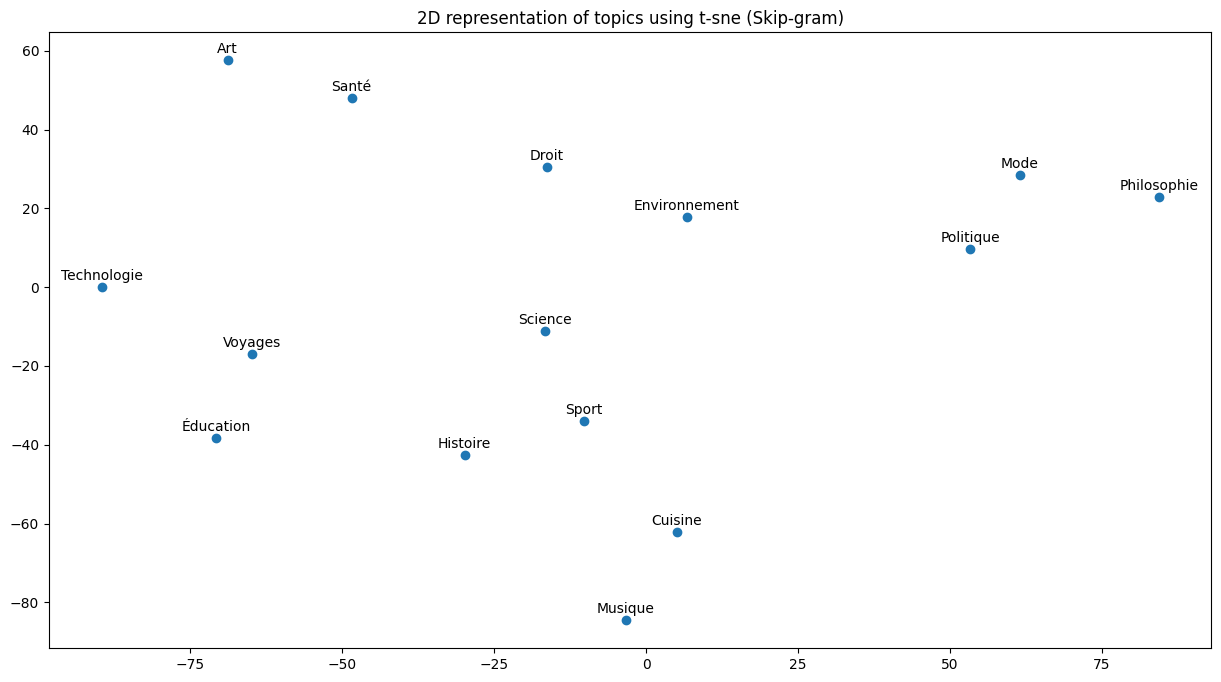

In [20]:
plt.figure(figsize=(15, 8))

plt.scatter(X_tsne_sg[:, 0], X_tsne_sg[:, 1])

plt.title("2D representation of topics using t-sne (Skip-gram)")

for i, label in enumerate(vocab_sg):
    
    plt.annotate(label, (X_tsne_sg[i, 0], X_tsne_sg[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()

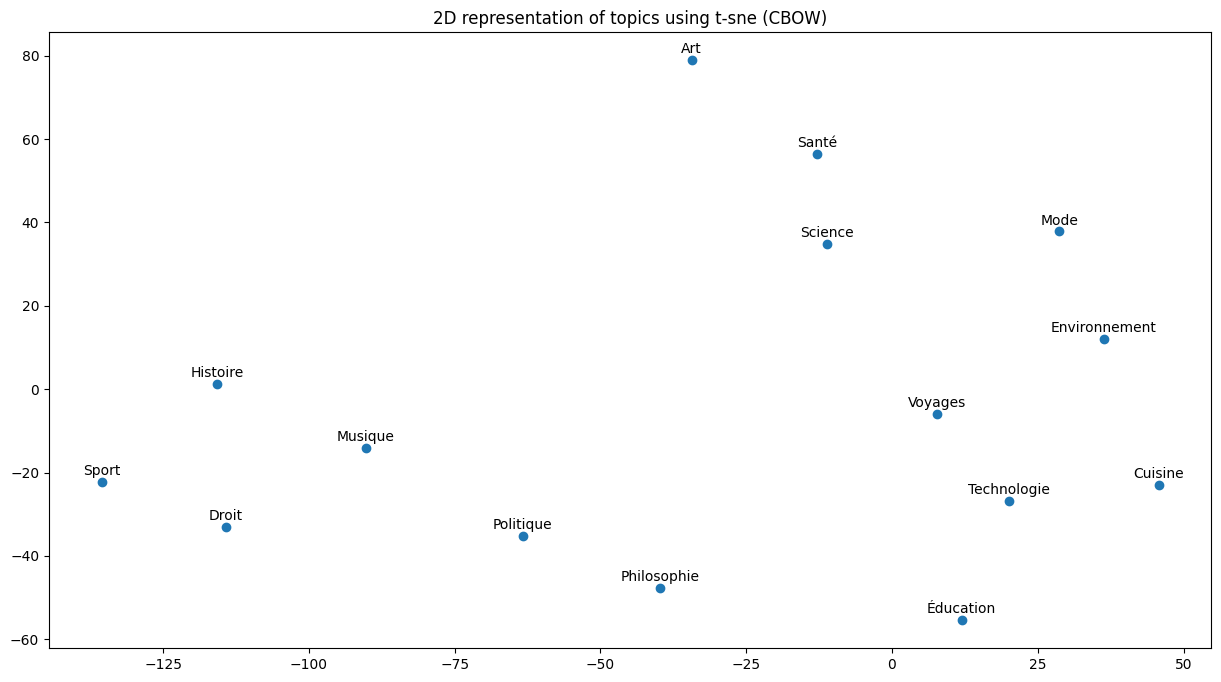

In [21]:
plt.figure(figsize=(15, 8))

plt.scatter(X_tsne_cbow[:, 0], X_tsne_cbow[:, 1])

plt.title("2D representation of topics using t-sne (CBOW)")

for i, label in enumerate(vocab_cbow):
    
    plt.annotate(label, (X_tsne_cbow[i, 0], X_tsne_cbow[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()

### UMAP dimensionality reduction

**UMAP (Uniform Manifold Approximation and Projection):**
- UMAP is another dimensionality reduction technique, similar to t-SNE, designed for preserving both local and global structures in the data.
- It uses a manifold-based approach to create a low-dimensional representation, emphasizing a more global preservation of distances compared to t-SNE.
- Generally faster than t-SNE and offers more control over the trade-off between preserving local and global structures.

In [22]:
from umap import UMAP

# Perform dimensionality reduction using umap for skip gram
umpa = UMAP(n_neighbors=5, n_components=2)
X_umap_sg = tsne.fit_transform(X_sg)

In [23]:
#For CBOW
umpa = UMAP(n_neighbors=5, n_components=2)
X_umap_cbow = tsne.fit_transform(X_cbow)

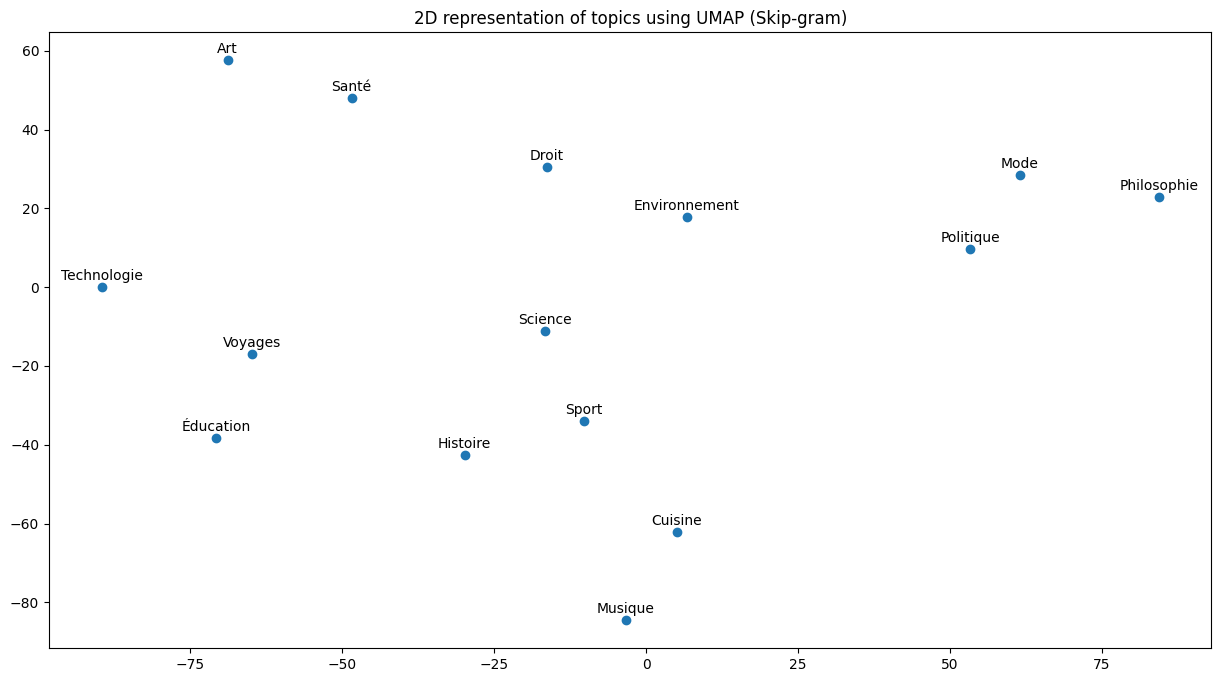

In [24]:
plt.figure(figsize=(15, 8))

plt.scatter(X_umap_sg[:, 0], X_umap_sg[:, 1])

plt.title("2D representation of topics using UMAP (Skip-gram)")

for i, label in enumerate(vocab_sg):
    
    plt.annotate(label, (X_umap_sg[i, 0], X_umap_sg[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()

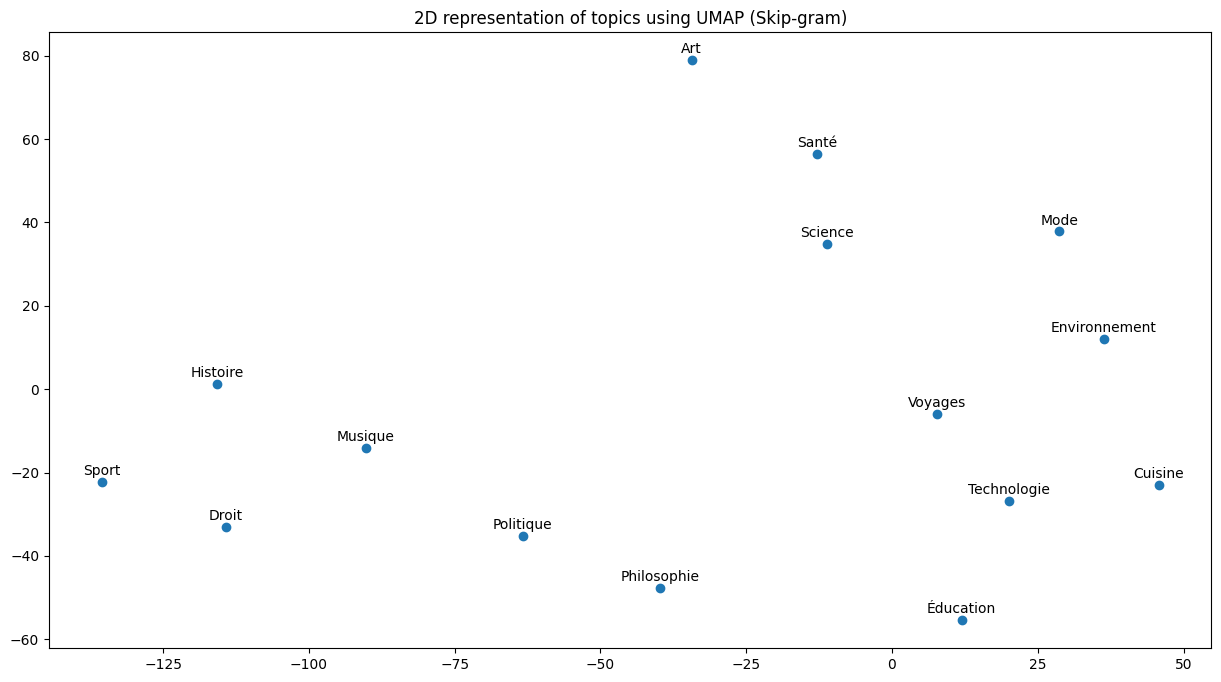

In [25]:
plt.figure(figsize=(15, 8))

plt.scatter(X_umap_cbow[:, 0], X_umap_cbow[:, 1])

plt.title("2D representation of topics using UMAP (Skip-gram)")

for i, label in enumerate(vocab_sg):
    
    plt.annotate(label, (X_umap_cbow[i, 0], X_umap_cbow[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()

**Differences:**
- **Computational Efficiency:** UMAP is often faster than t-SNE, making it more suitable for large datasets.
- **Preservation of Global Structure:** UMAP tends to better preserve the global structure of the data compared to t-SNE.
- **Adjustable Parameters:** UMAP provides more control over the trade-off between preserving local and global structures through adjustable parameters.

In summary, both t-SNE and UMAP are dimensionality reduction techniques, with t-SNE focusing on preserving pairwise similarities and local structures, while UMAP emphasizes a more balanced preservation of local and global structures and is often more computationally efficient.

## 2.2 TDA

Before we commence with TDA, we need to transform each session from a sequence of words into a sequence of vectors.

In [26]:
#Create a dictionary to map each theme with it's representation
themes_vectors_sg_tsne = {theme: X_tsne_sg[i] for i, theme in enumerate(vocab_sg)}

themes_vectors_sg_umap = {theme: X_umap_sg[i] for i, theme in enumerate(vocab_sg)}

themes_vectors_cbow_tsne = {theme: X_tsne_cbow[i] for i, theme in enumerate(vocab_cbow)}

themes_vectors_cbow_umap = {theme: X_umap_cbow[i] for i, theme in enumerate(vocab_cbow)}

This is how the representations should look like for skip-gram tsne embedding for example.

In [27]:
themes_vectors_sg_tsne

{'Droit': array([-16.27606,  30.57855], dtype=float32),
 'Science': array([-16.64404 , -11.221279], dtype=float32),
 'Sport': array([-10.210425, -33.86861 ], dtype=float32),
 'Environnement': array([ 6.6884546, 17.769484 ], dtype=float32),
 'Cuisine': array([  5.057963, -62.05938 ], dtype=float32),
 'Musique': array([ -3.3034468, -84.55191  ], dtype=float32),
 'Éducation': array([-70.72924 , -38.326912], dtype=float32),
 'Mode': array([61.491524, 28.467836], dtype=float32),
 'Santé': array([-48.440044,  48.06782 ], dtype=float32),
 'Histoire': array([-29.872868, -42.565914], dtype=float32),
 'Philosophie': array([84.31918 , 22.775537], dtype=float32),
 'Voyages': array([-64.90326 , -16.990139], dtype=float32),
 'Art': array([-68.82728 ,  57.567875], dtype=float32),
 'Politique': array([53.350613,  9.58693 ], dtype=float32),
 'Technologie': array([-89.54645   ,   0.12663354], dtype=float32)}

In [28]:
def themes_to_vectors(theme_names_list, theme_representation_dict):
    """
    Convert a list of lists of theme names into a list of lists of vectors using a theme representation dictionary.

    Parameters:
        theme_names_list (list): List of lists where each inner list contains theme names.
        theme_representation_dict (dict): Dictionary mapping theme names to their vector representations.

    Returns:
        list: List of lists where each inner list contains vectors corresponding to the theme names.
    """
    vectors_list = []

    for inner_list in theme_names_list:
        vectorized_inner_list = np.array([theme_representation_dict[theme] for theme in inner_list])
        vectors_list.append(vectorized_inner_list)

    return vectors_list

In [29]:
points_clouds_sg_tsne = themes_to_vectors(corpus, themes_vectors_sg_tsne)

points_clouds_sg_umap = themes_to_vectors(corpus, themes_vectors_sg_umap)

points_clouds_cbow_tsne = themes_to_vectors(corpus, themes_vectors_sg_tsne)

points_clouds_cbow_umap = themes_to_vectors(corpus, themes_vectors_cbow_umap)

The next step is to construct homology diagrams to observe the persistent patterns in the data.

In [30]:
from gtda.homology import VietorisRipsPersistence

homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

diagrams_sg_tsne= persistence.fit_transform(points_clouds_sg_tsne)

This is an example of a persistence diagram.

In [31]:
#You can try with different values
diagrams_sg_tsne[0]

array([[ 0.        , 64.73197174,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [61.06373978, 61.06373978,  1.        ],
       [61.06373978, 61.06373978,  1.        ],
       [ 0.        ,  0.        ,  2.        ]])

The first column corresponds to the birth of a pattern, the second column represents the death, and the third column indicates the dimension of the pattern.

In [32]:
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

diagrams_sg_umap= persistence.fit_transform(points_clouds_sg_umap)

In [33]:
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

diagrams_cbow_tsne= persistence.fit_transform(points_clouds_cbow_tsne)

In [34]:
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

diagrams_cbow_umap= persistence.fit_transform(points_clouds_cbow_umap)

Next transform the persistence diagrams into features before applying a clustering algorithm.

In [35]:
from gtda.diagrams import PersistenceEntropy

persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
patterns_sg_tsne = persistence_entropy.fit_transform(diagrams_sg_tsne)

In [36]:
persistence_entropy = PersistenceEntropy()


patterns_sg_umap = persistence_entropy.fit_transform(diagrams_sg_umap)

In [37]:
persistence_entropy = PersistenceEntropy()


patterns_cbow_tsne = persistence_entropy.fit_transform(diagrams_cbow_tsne)

In [38]:
persistence_entropy = PersistenceEntropy()


patterns_cbow_umap = persistence_entropy.fit_transform(diagrams_cbow_umap)

## 2.3 Create clusters

In this part we will create clusters using the representations we got from the last part

### KMeans clustering

In [39]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from tqdm.auto import tqdm

In [40]:
#use the Mini Batch Kmeans and find the best cluster based on the silhouette score

def mini_batch_clustering(data, k_limit=10, batch_size=100, random_state=None):

    best_k = 2  # Minimum value for k
    inertia_scores = []
    silhouette_scores = []

    for k in tqdm(range(2, k_limit + 1)):
        # Mini Batch K-Means clustering
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=random_state)
        labels = kmeans.fit_predict(data)

        # Inertia (within-cluster sum of squared distances)
        inertia_scores.append(kmeans.inertia_)

        # Silhouette Score
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)

        # Update best k based on silhouette score
        if silhouette_avg > silhouette_scores[best_k - 2]:  # -2 because range starts from 2
            best_k = k

    return best_k, inertia_scores, silhouette_scores

In [41]:
best_k, inertia_scores1, silhouette_scores1 = mini_batch_clustering(patterns_sg_tsne, batch_size=4_000)

print("Best k:", best_k)

  0%|          | 0/9 [00:00<?, ?it/s]

Best k: 8


In [42]:
best_k, inertia_scores2, silhouette_scores2 = mini_batch_clustering(patterns_sg_umap, batch_size=4_000)

print("Best k:", best_k)

  0%|          | 0/9 [00:00<?, ?it/s]

Best k: 8


In [43]:
best_k, inertia_scores3, silhouette_scores3 = mini_batch_clustering(patterns_cbow_tsne, batch_size=4_000)

print("Best k:", best_k)

  0%|          | 0/9 [00:00<?, ?it/s]

Best k: 9


In [44]:
best_k, inertia_scores4, silhouette_scores4 = mini_batch_clustering(patterns_cbow_umap, batch_size=4_000)

print("Best k:", best_k)

  0%|          | 0/9 [00:00<?, ?it/s]

Best k: 9


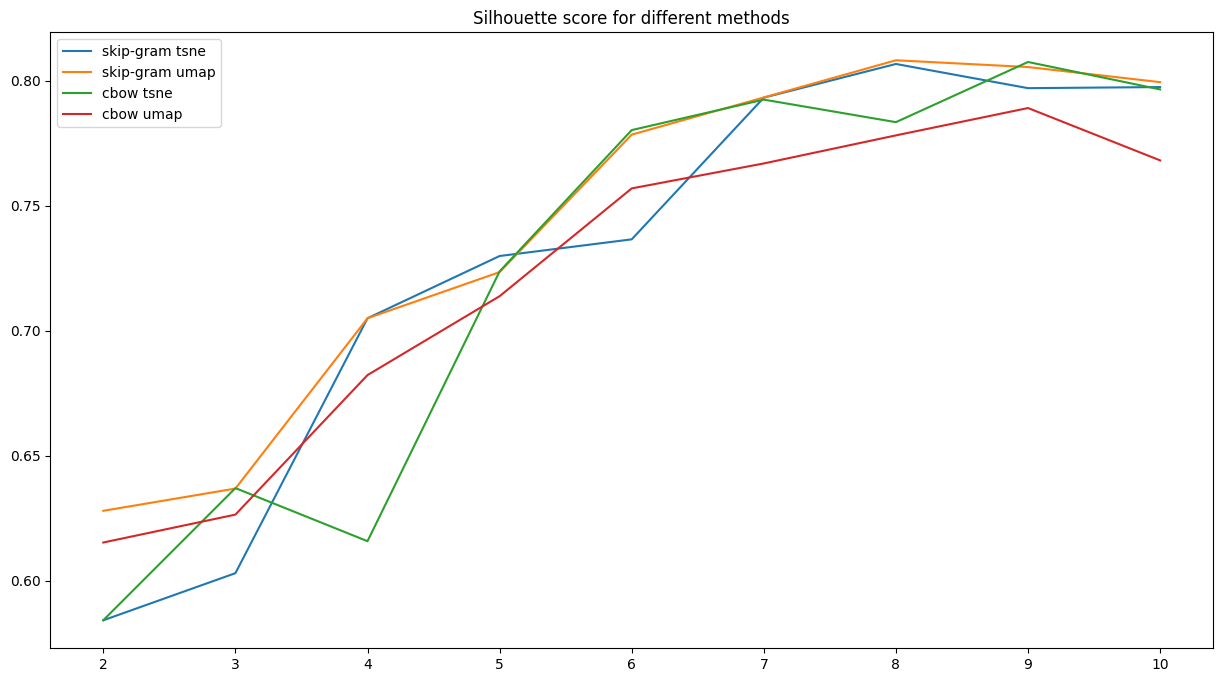

In [45]:
plt.figure(figsize=(15, 8))

plt.title("Silhouette score for different methods")

plt.plot(np.arange(2, 11), silhouette_scores1, label="skip-gram tsne")

plt.plot(np.arange(2, 11), silhouette_scores2, label="skip-gram umap")

plt.plot(np.arange(2, 11), silhouette_scores3, label="cbow tsne")

plt.plot(np.arange(2, 11), silhouette_scores4, label="cbow umap")

plt.legend()

plt.show()

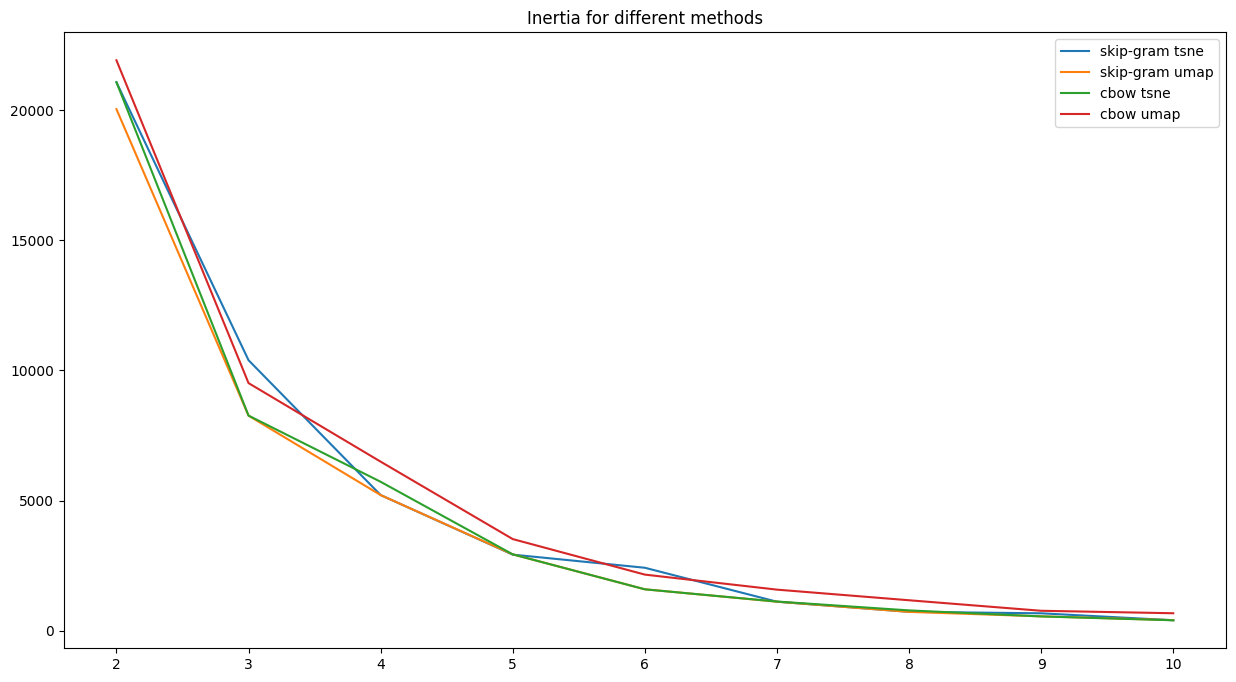

In [53]:
plt.figure(figsize=(15, 8))

plt.title("Inertia for different methods")

plt.plot(np.arange(2, 11), inertia_scores1, label='skip-gram tsne')

plt.plot(np.arange(2, 11), inertia_scores2, label='skip-gram umap')

plt.plot(np.arange(2, 11), inertia_scores3, label='cbow tsne')

plt.plot(np.arange(2, 11), inertia_scores4, label='cbow umap')

plt.legend()

plt.show()

In [54]:
kmeans = MiniBatchKMeans(n_clusters=5, batch_size=4_000)

labels1 = kmeans.fit_predict(patterns_sg_tsne)

In [55]:
kmeans = MiniBatchKMeans(n_clusters=6, batch_size=4_000)

labels2 = kmeans.fit_predict(patterns_sg_umap)

In [56]:
kmeans = MiniBatchKMeans(n_clusters=6, batch_size=4_000)

labels3 = kmeans.fit_predict(patterns_cbow_tsne)

In [57]:
kmeans = MiniBatchKMeans(n_clusters=5, batch_size=4_000)

labels4 = kmeans.fit_predict(patterns_cbow_umap)

This method can give some examples that are closed to clusters centroid, if we want to have an idea of what kind of elements are contained in the cluster.

In [58]:
def get_closest_points_indices(data, k=3, n_closest=1, batch_size=100, n_init=10, random_state=None):

    # Mini Batch K-Means clustering
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init=n_init, random_state=random_state)
    labels = kmeans.fit_predict(data)

    # Initialize dictionary to store closest point indices for each cluster
    closest_points_indices = {cluster: [] for cluster in range(k)}

    # Find the N most close data points for each cluster
    for cluster in range(k):
        cluster_mask = (labels == cluster)
        cluster_data = data[cluster_mask]
        centroid = kmeans.cluster_centers_[cluster]
        distances = np.linalg.norm(cluster_data - centroid, axis=1)
        closest_point_indices = np.argsort(distances)[:n_closest]
        closest_point_global_indices = np.where(cluster_mask)[0][closest_point_indices]
        closest_points_indices[cluster] = closest_point_global_indices.tolist()

    return closest_points_indices

In [59]:
closest_points_indices = get_closest_points_indices(patterns_sg_tsne, k=6, n_closest=10)

In [60]:
closest_points_indices[0]

[16011, 17015, 19506, 20245, 18446, 15460, 16917, 18650, 22518, 21443]

In [61]:
#Give examples of each cluster
behaviour_categories_examples = [[corpus[i] for i in closest_points_indices[j]] for j in range(6)]

Verify if the clustering give results similar to the ground truth of the genrated data.

In [62]:
ground_truth_labels = [np.ones(b[2])*i for i, b in enumerate(BEHAVIOURS_SPECIFY)]

ground_truth_labels = np.concatenate(ground_truth_labels)

In [63]:
ground_truth_labels[closest_points_indices[1]]

array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6.])

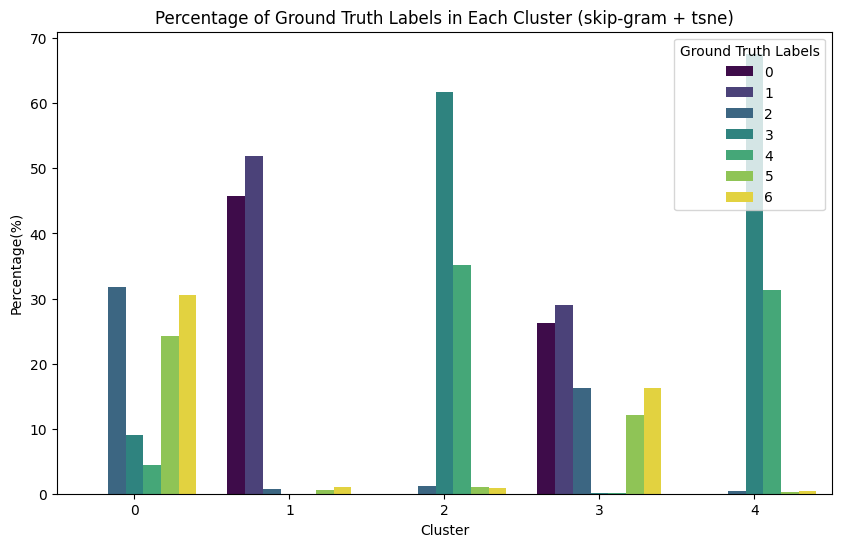

In [64]:
import seaborn as sns
from sklearn.metrics.cluster import contingency_matrix

def plot_cluster_barplot(cluster_labels, ground_truth_labels, title=""):

    contingency = contingency_matrix(cluster_labels, ground_truth_labels)


    percentages = (contingency.T / contingency.sum(axis=1)).T * 100

    x_values = np.arange(len(np.unique(cluster_labels)))

    percentages_flat = percentages.flatten()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=np.repeat(x_values, len(np.unique(ground_truth_labels))),
                y=percentages_flat, hue=np.tile(np.unique(ground_truth_labels), len(x_values)),
                palette="viridis", dodge=True)

    # Add labels and legend
    plt.xlabel('Cluster')
    plt.ylabel('Percentage(%)')
    plt.title('Percentage of Ground Truth Labels in Each Cluster '+title)
    plt.legend(title='Ground Truth Labels', loc='upper right')

    # Show the plot
    plt.show()


plot_cluster_barplot(labels1, ground_truth_labels, "(skip-gram + tsne)")

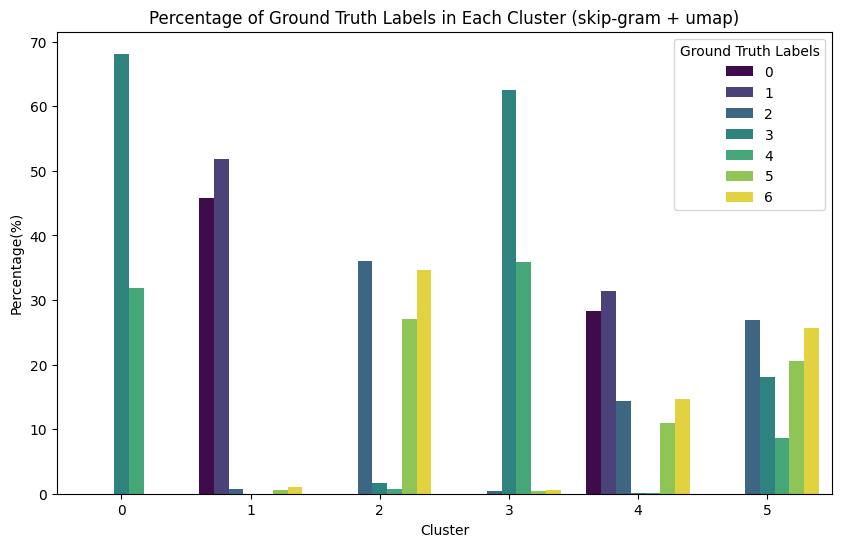

In [65]:
plot_cluster_barplot(labels2, ground_truth_labels, "(skip-gram + umap)")

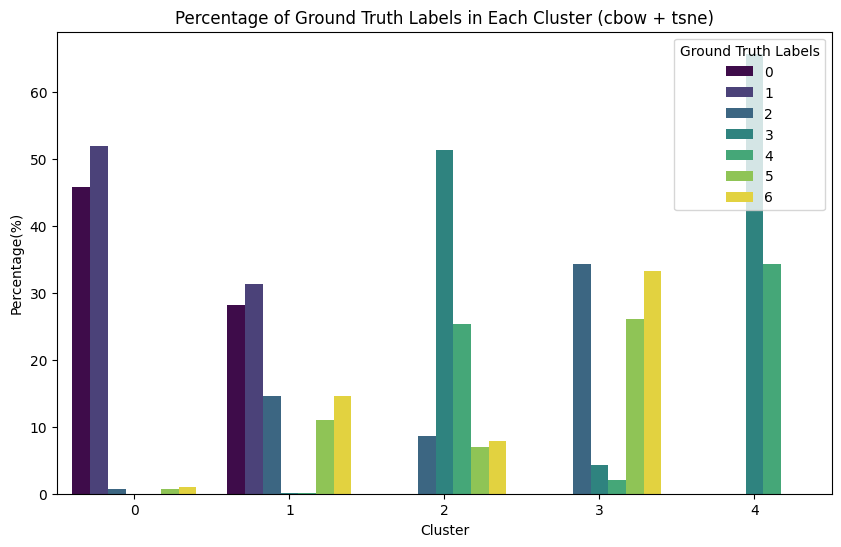

In [66]:
plot_cluster_barplot(labels3, ground_truth_labels, '(cbow + tsne)')

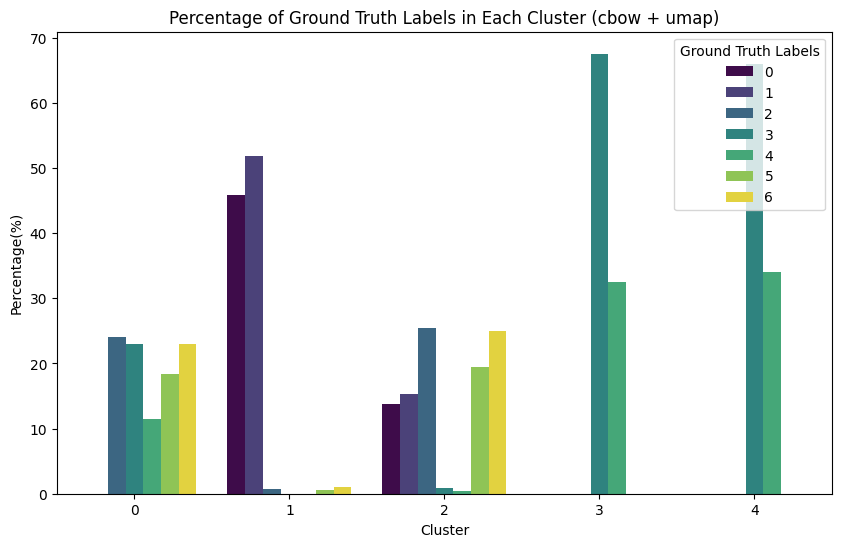

In [67]:
plot_cluster_barplot(labels4, ground_truth_labels, "(cbow + umap)")

### DBSCAN

In [68]:
from  sklearn.cluster import DBSCAN

dbscan = DBSCAN()

labels1 = dbscan.fit_predict(patterns_sg_tsne)

In [69]:
dbscan = DBSCAN()

labels2 = dbscan.fit_predict(patterns_sg_umap)

In [70]:
dbscan = DBSCAN()

labels3 = dbscan.fit_predict(patterns_cbow_tsne)

In [71]:
dbscan = DBSCAN()

labels4 = dbscan.fit_predict(patterns_cbow_umap)

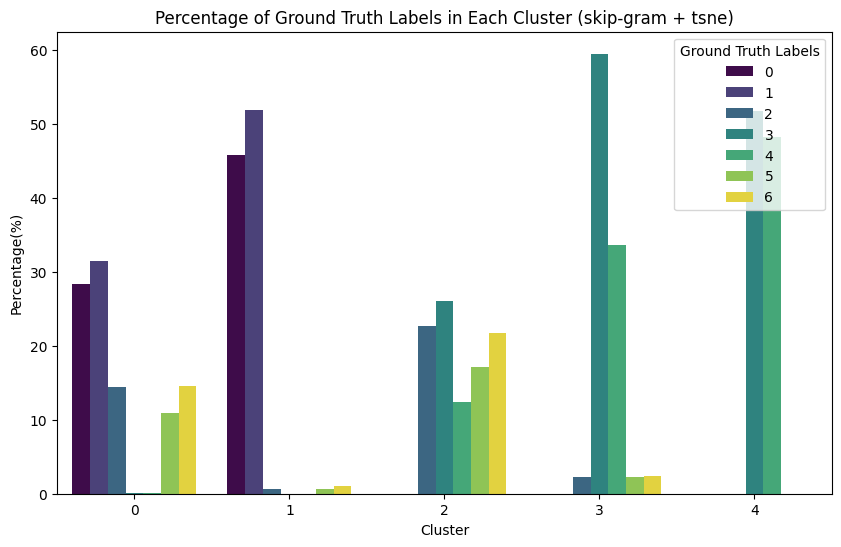

In [72]:
plot_cluster_barplot(labels1, ground_truth_labels, "(skip-gram + tsne)")

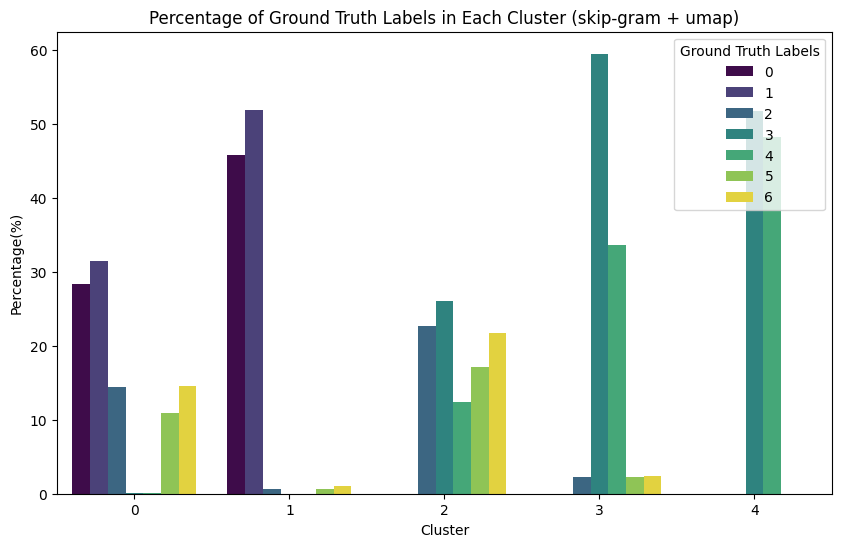

In [73]:
plot_cluster_barplot(labels2, ground_truth_labels, "(skip-gram + umap)")

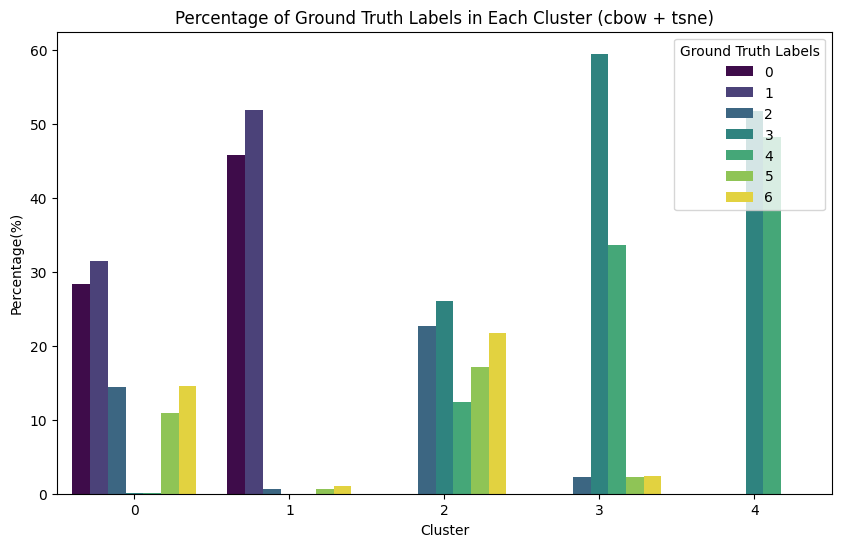

In [74]:
plot_cluster_barplot(labels3, ground_truth_labels, "(cbow + tsne)")

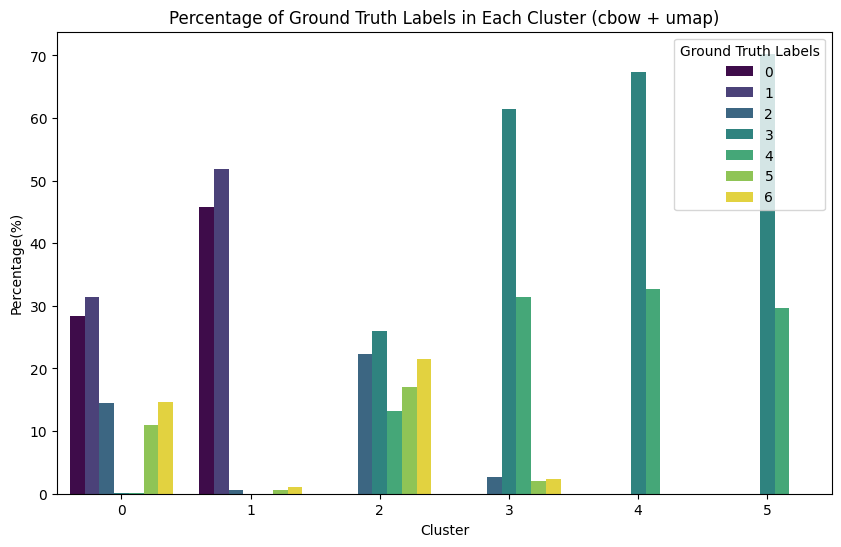

In [75]:
plot_cluster_barplot(labels4, ground_truth_labels, "(cbow + umap)")

# 3. Discussion & Optimizations

### This is a summary of the pipeline

![Figure Pipeline.png](<attachment:Figure Pipeline.png>)
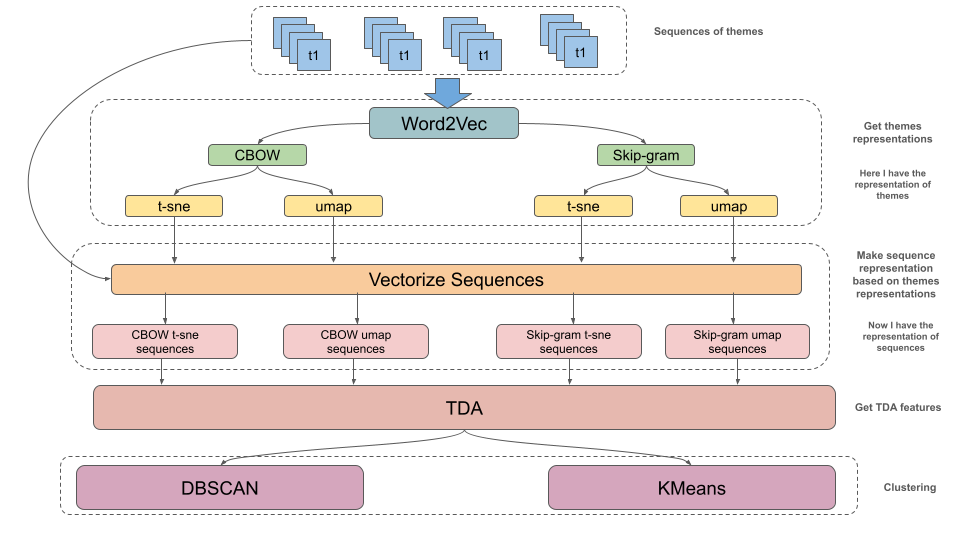

### Pipeline Description:

1. **Embedding Themes:**
   - Utilizing the word2vec algorithm, we obtain a semantic representation of themes in the form of vectors with a dimensionality of 50.

2. **Dimensionality Reduction:**
   - Attempting to reduce dimensionality, we aim for a vector size of 2 (using t-sne or umap).

3. **Vectorization of Sequences:**
   - Transforming the sequences into a vectorized format. Instead of [$theme_1$,..., $theme_n$], we represent them as [$(x_1, y_1)$, ..., $(x_n, y_n)$].

4. **Topological Data Analysis (TDA):**
   - Creating persistence diagrams during this stage with homology groups spanning from 0 to 2 dimensions.

5. **Persistence Entropy Computation:**
   - Computing the persistence entropy to obtain a vector of size three, reflecting the three homology groups (0, 1, and 2) (it follows the same entropy as in Shannon's theory with normalization).

6. **Clustering Algorithm:**
   - Applying a clustering algorithm of your choice to finalize the identification of clusters.


### Pipeline Justifications:

**1. Word Embedding with Word2Vec (Skip-gram):**
   - Word2Vec provides theme representations based on context, making themes with similar surroundings have close representations. A longer vector enhances the quality of the representation.

**2. Dimensionality Reduction:**
   - The dimensionality of the vectors is reduced to obtain summarized features conducive to generalization.

**3. Vectorization of Theme Sequences:**
   - The obtained theme representations are considered as sequences of vectors (2D matrix).

**4. Topological Data Analysis (TDA) - Persistence Diagrams:**
   - Persistence diagrams are computed by modifying the radius in the Vietoris-Rips complex to determine the birth and death dates of homologies. This aids in identifying persistent structures, such as cyclical forms.

**5. Persistence Entropy Computation:**
   - Persistence entropy is calculated to analyze the variety in birth and death values for each homology group (dimension). High entropy indicates diverse patterns in death-birth values, especially in dimension 0. Entropy helps differentiate sequences with a multitude of patterns.

**6. Clustering of Theme Sequences:**
   - The new representations of theme sequences, derived from TDA, are subjected to clustering to identify emergent clusters. Clustering allows for the recognition of different behaviours revealed by TDA.


### Critique of the Pipeline:

1. **Lack of Consideration for Semantic Relations:**
   - The Word2Vec approach captures contextual information but may overlook semantic relations between themes. Themes with similar context might not necessarily share meaningful semantic connections, leading to potential misrepresentations.

2. **Dimensionality Reduction Oversimplification:**
   - While reducing dimensionality is employed for generalization, the rationale for choosing a vector size of 2 is not well-justified. This oversimplified representation might result in the loss of crucial information, especially in capturing the diversity of themes.

3. **Persistence Entropy Interpretation Challenges:**
   - While computing persistence entropy provides insights into pattern variations, the interpretation of high entropy values lacks specificity. It remains unclear how these values directly contribute to the understanding of theme sequences or clusters.

4. **Lack of Evaluation Metrics:**
   - The pipeline does not mention any metrics for evaluating the quality of the obtained clusters or the overall performance of the pipeline. Without defined evaluation criteria, it is challenging to assess the effectiveness of the proposed approach.

5. **Not well suited for short sequences:**
   - It is not possible to get representations of short sequences, while they can contain interesting information.


### Optimizations

For the optimizations I recomand you to check the **new_tda.ipynb** file.